In this project, you will be working with the protein interaction network (PIN) of *Saccharomyces cerevisiae* from the BioGRID Multi-Validated (MV) Datasets. The nodes and edges of this PIN denote proteins and their physical interactions, respectively. These interactions have been identified from large-scale protein interaction experiments such as yeast two-hybrid screenings and affinity purification with mass spectrometry. Additionally, they pass a specific set of criteria as defined [here](https://wiki.thebiogrid.org/doku.php/biogrid_mv) (BioGRID MV Datasets). See the following [link](https://wiki.thebiogrid.org/doku.php/biogrid_tab_version_2.0) to familiarize yourself with the contents of this BioGRID file. You will be analyzing the yeast PIN using *k*-core analysis, and further use the network as a scaffold for incorporating gene expression data, allowing you to perform *s*-core analysis using pairwise gene expression correlations as weights.

### 1.1 Yeast protein interaction network

Download the file containing all multi-validated protein-protein interactions from BioGRID found on Blackboard `BioGRID_PIN.txt`. Create a network with NetworkX using the systematic names to set source and target nodes. These corresponds to the columns named `Systematic Name Interactor A` and `Systematic Name Interactor B`. Remove all self-edges from the network.

<span style="color:red">

***

**NB! I have created my own module with functions that I have been using several times, both in project 1 and 2. The content of the module is printed out in the Appendix of this document. It is likely to change from project to project.**

*** 

In [44]:
# Imports 
import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network
import sys
import os
if sys.path[-1] != "..":
    sys.path.append("..")
from SysBio_fun import *
from tbtFunctions import *

In [45]:
# Read file:
df = pd.read_table("BioGRID_PIN.txt", sep="\t", low_memory=False)

# Define source and target column:
source = "Systematic Name Interactor A"
target = "Systematic Name Interactor B"
# source = "Official Symbol Interactor A"
# target = "Official Symbol Interactor B"
# Rename columns:
df.rename(columns={source:"source", 
                   target:"target"},
                   inplace=True)
# Drop rows where column "source" value is identical to column "target" value.
# I.e., drop self loops:
# **NB!** This the number of rows left in the df may vary depending on which
# column-pairs were treated as source-target. E.g. source:"-" and target:"-"
# will be removed, even though they may have different Entrez ID.
df = df[df["source"] != df["target"]]

# Generate the graph:
# **NB!** I treat the graph as undirected. 
PIN = nx.from_pandas_edgelist(df, edge_attr=True, create_using=nx.Graph())



(i) How large is the network (i.e. number of nodes and edges), and what is the average node degree? 

In [46]:
N = PIN.number_of_nodes()
E = PIN.number_of_edges()
mean_k = (E*2)/N  # Average node degree. Each link contributes a degree "point" for each node it connects. Therefore 2*E

print(f"""
The number of nodes are: {N}
The number of edges are: {E}
The average node degree is: {mean_k} 
""")


The number of nodes are: 13443
The number of edges are: 31756
The average node degree is: 4.724540653128022 



(ii) Look up *S. cerevisiae* S288C in the NCBI Taxonomy Database [here](https://www.ncbi.nlm.nih.gov/taxonomy) and take note of the taxonomy ID. Using the `Organism Interactor A` and `Organism Interactor B` edge attributes in the network, use this taxonomy ID to filter out all non-*S. cerevisiae* S288C nodes from the network. Also, remove all self-loops and isolated nodes. How many nodes and edges remain? Create a plot of its degree distribution. How would you characterize this network and its degree distribution?

In [47]:
# The taxonomic ID of S. cerevisiae S288C is: 559292

# Generate a list of edges that does not fit:
r1 = [edge for edge,tax \
      in nx.get_edge_attributes(PIN, "Organism Interactor A").items() \
          if tax != 559292]  # The edge information is a tuple and the key
r2 = [edge for edge,tax \
      in nx.get_edge_attributes(PIN, "Organism Interactor B").items() \
        if tax != 559292]
rem = set(r1+r2)  # set() is used to remove potential duplicates
# Use the list to remove all edges 
PIN.remove_edges_from(rem)
# In pandas:
# len(df[(df["Organism Interactor A"] == 559292) & (df["Organism Interactor B"] == 559292)])


# Remove nodes with a node degree of 0 (i.e. isolated nodes):
PIN.remove_nodes_from(  # Remove nodes from list ...
    [nodes for nodes,degree \
     in dict(PIN.degree()).items() if degree == 0]  # nodes with degree 0
)

N = PIN.number_of_nodes()  # New number of nodes
E = PIN.number_of_edges()  # New number of edges

print(f"""
The number of nodes is now {N},
while number of edges is {E}
""")


The number of nodes is now 4104,
while number of edges is 16753



(iii) Compare the yeast PIN with Barabási–Albert (BA) and Erdős–Rényi (ER) networks with approximately the same number of nodes and edges using a few selected network measurements and the degree distributions. Do these models do a good job in describing the yeast PIN? Discuss why/why not.

In [48]:
l_comp = nx.Graph(PIN.subgraph(
    sorted(
        nx.connected_components(
            PIN.copy()
            #nx.to_undirected(PIN.copy())
            #PIN.copy().to_undirected(as_view=True)
            ),
        reverse=True
    )[0]
).copy())

n = l_comp.number_of_nodes()
e = l_comp.number_of_edges()

ER = connected_ER(n, e)
BA = connected_BA(n, round(round(e/n)))


In [50]:
graph_info(l_comp, basic=True)
graph_info(ER, basic=True)
graph_info(BA, basic=True)


Number of nodes: 4022
Number of edges: 16700

Number of nodes: 4022
Number of edges: 16700

Number of nodes: 4022
Number of edges: 16072


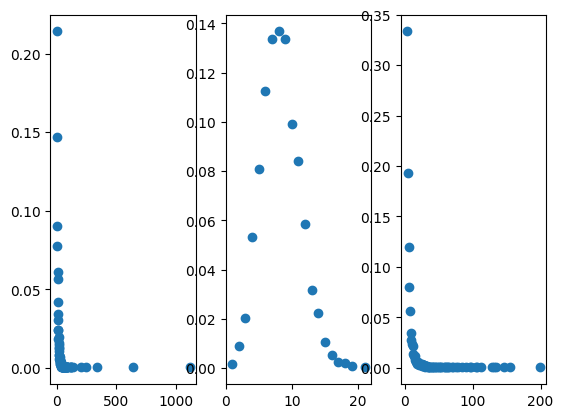

In [51]:
x_l_comp, y_l_comp = degree_distribution(l_comp)
x_ER, y_ER = degree_distribution(ER)
x_BA, y_BA = degree_distribution(BA)

multi_plot(plot_type="scatter", 
           lst_of_xs=[x_l_comp, x_ER, x_BA],
           lst_of_ys=[y_l_comp, y_ER, y_BA])

<span style="color:blue">
As seen from the figure both the PIN and BA network have a power-law degree distribution, while the degree distribution for the ER is bell-shaped. 

(iv) You will now start peeling away layers of the yeast PIN by $k$-core analysis. In your own words, describe/define *k*-core analysis, and explain how it works on a network. What network does the 1-core correspond to?

<span style="color:blue">
k-core analysis is a method to identify importance of nodes by how connected they are to other nodes. Nodes with few links are removed stepwise until you end up with a core of nodes that have many connections in the original network, in addition to being tightly connected between themselves. For each iteration of the method a layer of nodes are removed. The first core (i.e. the 1-core) consists of nodes that have a single link or more, i.e. a node degree $\ge$1. This core is therefore the entire network. The 2-core is the network after we have removed all nodes with a degree of 1, in addition to the nodes that now ends up with a degree of 1 following the first removal. In the 2-core network all nodes will have a node degree $\ge$2. When all nodes with a degree of 2, and those who suddenly get a node degree $\le$, are removed we are left with the 3 core and the next iteration can begin.

Pseudo code:
k-core = 1
while number of nodes in network > 0:
    while any node with degree == k-core:
        Remove nodes with node degree $\le$ k-core        
    return network
    k-core = k-core + 1

(v) Calculate the 2-core of the yeast PIN. How large is this network? Plot and characterize its degree distribution and compare it to the original yeast PIN.


Number of nodes: 3102
Number of edges: 15780


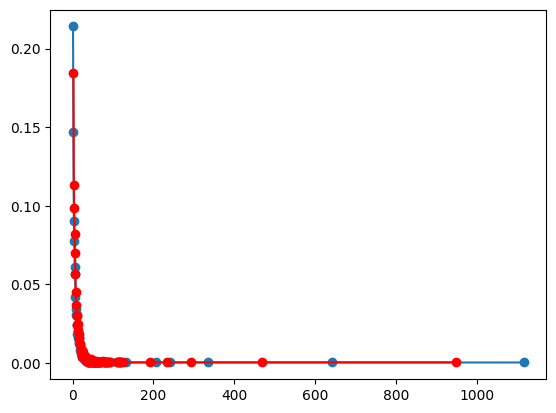

In [52]:
l_comp_2_core = nx.k_core(l_comp, k=2)
graph_info(l_comp_2_core, basic=True)

x, y = degree_distribution(l_comp_2_core)
plt.plot(x_l_comp,y_l_comp, 'o-')
plt.plot(x, y, 'o-', color="red")
plt.show()

<span style="color:blue">
As seen on the figure above, the degree distribution has almost identical shape (i.e. power-law) for the 1- and 2-core. However, the frequency of nodes with degree 2 in the 2-core is lower than the frewuency of nodes with degree 1 in the 1-core. Similarly, the greatest node degree for the 1-core (~1100) is higher than the greatest node degree for the 2-core (~950).

(vi)  Find the innermost *k*-core (the last *k* before the network is empty). How many edges and nodes are there in the innermost *k*-core? What is the absolute maximal amount of edges that there could be between this number of nodes, and how does the innermost core compare to that?

In [53]:
current_k = 0
g = l_comp.copy()  # Copy of the largest component of PIN
while True:
    if nx.number_of_nodes(g) == 0:
        break 
    else:
        current_k += 1
        g = nx.k_core(g, k=current_k)  # get the k-core of the graph

# The innermost k-core:
innermost_k_core = current_k-1  

print(f"The innermost k-core is: {innermost_k_core}")

graph_info(nx.k_core(l_comp.copy(), k=innermost_k_core), basic=True)

The innermost k-core is: 18

Number of nodes: 19
Number of edges: 171


<span style="color:blue">
The innermost core can be a clique, i.e. a complete graph, where all nodes are connected to all other nodes, and the number of edges would then be $E = \frac{N(N-1)}{2}$. The 18-core of the PIN network (or rather the largest component of the PIN network) has 19 edges, which result in a theoretical maximum of 171 edges, which happens to be the exact number of edges in the innermost k-core. 

(vii) Create a plot of the number of nodes and the number of edges in a *k*-core against *k*. How would you characterize this plot? What does it tell you?

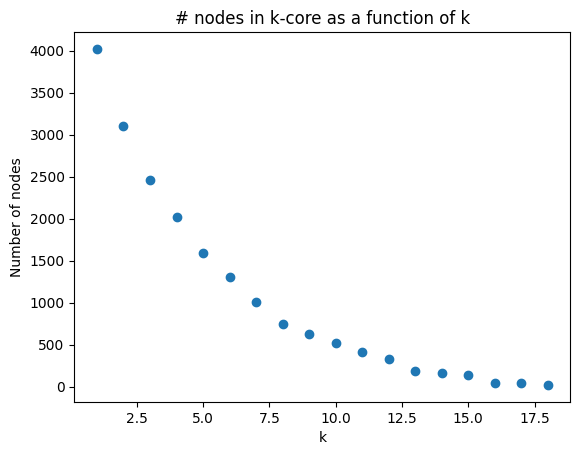

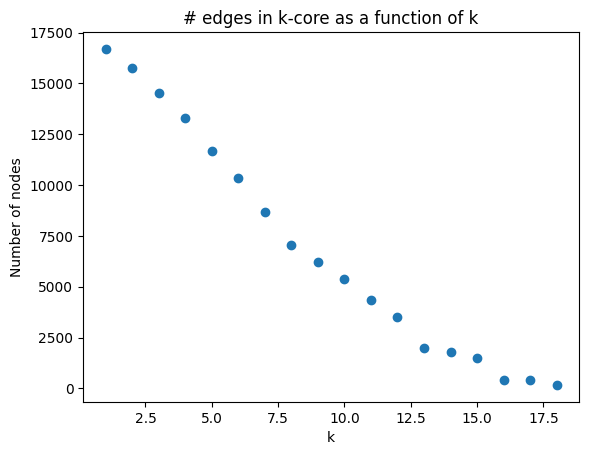

In [54]:
# Number of nodes in all the k-cores:
y_nodes = [nx.number_of_nodes(nx.k_core(l_comp.copy(), k=k_)) for k_ in range(1, innermost_k_core+1)]
# Number of edges in all the k-cores:
y_edges = [nx.number_of_edges(nx.k_core(l_comp.copy(), k=k_)) for k_ in range(1, innermost_k_core+1)]
# The the k-cores:
x = range(1, innermost_k_core+1)

# Plot # nodes in k-core as a function of k
plt.scatter(x, y_nodes)
nice_plot("# nodes in k-core as a function of k", "k", "Number of nodes")

# Plot # edges in k-core as a function of k
plt.scatter(x, y_edges)
nice_plot("# edges in k-core as a function of k", "k", "Number of nodes")

<span style="color:blue">
I would say that the number of nodes in the k-core as a function of k almost follow a "slow" power-law, while the number of edges in the k-core as a function of k is more linear. I guess that for the nodes this makes sense given that a PIN network (usually) is scale-free, which also means that preferential-attachment has occured during the creation of the network. I.e. when a new node is added it is more likely to 

(viii) Generate the second innermost $k$-core and visualize it using pyvis. Describe the network.

In [55]:
sec_inner = nx.k_core(l_comp.copy(), k=innermost_k_core-1)
show_html(sec_inner, name=f"{innermost_k_core-1}-core_network", show=True, size="large", more=True)

<span style="color:blue">
The 17-core (i.e. the secound innermost k-core) network seems to consists of two clusters/communities, where the nodes in these are tightly connected. I guess that one of these are the 18-core (i.e. the innermost k-kore). There are three links that connects these two, and I expect the nodes that are bind by these links to have an exeptionally high betweenness-centrality (given that the links works as bridges). 

(ix)  We will now load gene expression data onto our yeast PIN. Go to this [url](https://www.ebi.ac.uk/gxa/experiments/E-GEOD-20591/Results) containing the gene expression data set from *Transcription profiling by array of yeast to investigate expression of the beta-subunit of Snf1 kinase*. For those interested, you can find detailed information about the dataset in the original publication [here](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2958.2010.07209.x). Download `normalized_expressions.tsv` from Blackboard and import the list of gene names, as well as corresponding expression data from 24 experimental conditions. For all pairwise gene combinations, calculate the Pearson correlation coefficients and associated p-values for the *N* genes present in the yeast PIN (both as *N* x *N* Numpy arrays). Out of the gene pairs with positive correlation values, how many of them have a significance value below 0.0001?

In [56]:
## NB! This is a more or less a direct copy from Eivind's reply to one of the questions
## on the BlackBoard discussion board (Thread: project 2 Pearson correlation coefficient).

norm_ex = pd.read_table("normalized_expressions.tsv", sep="\t")  # Read gene expression data


#Filter out PIN-genes not in the yeast PIN:
PIN_genes = list(l_comp.nodes()) 
norm_ex = norm_ex[norm_ex["Gene ID"].isin(PIN_genes)] 

# There seems to be duplicates in the expression level dataframe:
print(f"""
The number of rows in the expression level dataframe: {len(norm_ex["Gene ID"].to_numpy())}
The number of unique rows (i.e. unique genes): {len(set(norm_ex["Gene ID"].to_numpy()))}
The number of overlapps/duplicates is: {len(norm_ex["Gene ID"].to_numpy())-len(set(norm_ex["Gene ID"].to_numpy()))} 
""")

# Remove duplicated rows (in the "Gene ID" column):
norm_ex = norm_ex.drop_duplicates(subset=["Gene ID"])

# The expression data seems to not cover all the nodes in the network:
print(f"""
There are {len(list(set(PIN_genes)-set(norm_ex["Gene ID"].to_numpy())))} nodes in the network that have no expression data.
""")
# Remove nodes with no expression data:
l_comp.remove_nodes_from(list(set(PIN_genes)-set(norm_ex["Gene ID"].to_numpy())))


# Update the list of nodes:
PIN_genes = list(l_comp.nodes()) 

# Convert expression data columns to NumPy arrays:
gene_exp = norm_ex.iloc[:, 1:].to_numpy() 

# Calculate Pearson correlations and associated p-values:
corrmat, pmat = faster_corrcoef(gene_exp)  



# And now, you have the correlation matrix as well as the related p-value matrix. Necessary to loop through the correlation matrix and only count the correlations that have P-values < 1E-4.


The number of rows in the expression level dataframe: 3961
The number of unique rows (i.e. unique genes): 3924
The number of overlapps/duplicates is: 37 


There are 98 nodes in the network that have no expression data.



In [57]:
# I don't know how to calculate how many has a p-value less than 0.0001
# I thought it would be something like:
np.count_nonzero(pmat < 0.0001)/2

424578.0

(x) Download `s_core.py`. This is similar to the NetworkX function `k_core`, but uses node strength instead of node degree. Strength is defined as the sum of the weights of all the links attached to a node (i.e. Person correlations). With negative weights, the absolute values of the weights are used to calculate the strength. In this case, however, we are only looking at positively correlated nodes. Do you think it would make sense to include negative correlations in this particular case? Discuss.

(xi) Calculate the *s*-core with *s* = 2.5, 3, 3.5, and 4, and characterize their degree distributions. Discuss how the distribution changes for increasing values of *s*.

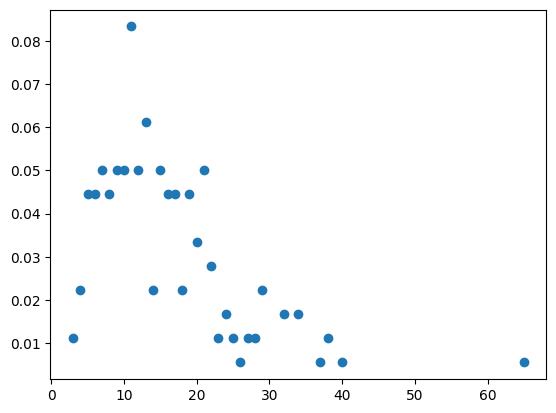

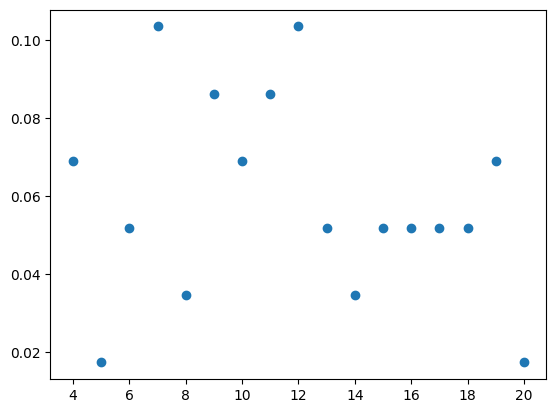

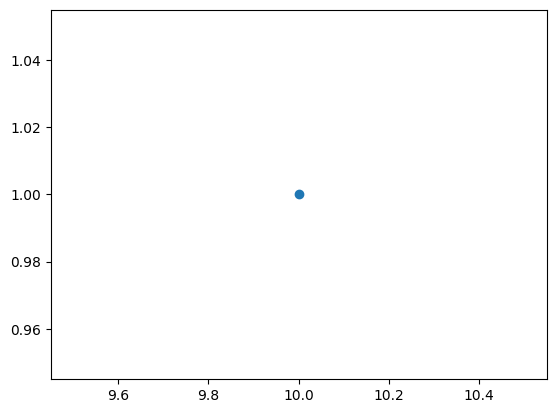

s = 4 is not possible. Broke the loop!


In [75]:
s_lst = [2.5, 3, 3.5, 4]  
xs = []  # Storage list for the degrees
ys = []  # Storage list for the fractions
for i in range(len(s_lst)):
    g_s_core = s_core(G=l_comp, s=s_lst[i], genes=PIN_genes, corrmat=corrmat, pmat=pmat)
    # Check if the number of nodes is 0:
    if g_s_core.number_of_nodes() == 0:
        innermost_s_core = s_lst[i]
        print(f"s = {s_lst[i]} is not possible. Broke the loop!")
        break  # The innermost s-core was the previous graph!
    # Calculate the degree distribution
    x, y = degree_distribution(g_s_core)
    xs.append(x)  # Append the list of x-values to the storage list
    ys.append(y)  # Append the list of y-values to the storage list
    plt.scatter(x,y)
    plt.show()
# Plot the degree distributions
# multi_plot("scatter", xs, ys)
# plt.show()

<span style="color:blue">
Based on the result I got, I must say that the degree distribution for the 2.5-core seems to be bell-shaped. Although, it is not a smooth bell-shape. The 3-core seems to have a degree distribution that is random, and 3.5-core cosists only of nodes with degrees of 11.

(xii) Find an integer value for *s* that gives as good match as possible relative to the second innermost *k*-core in terms of number of distinct modules and number of nodes. Visualize this *s*-core with pyvis and describe the network.

<span style="color:blue">
Well, for me the second innermost s-core must be the core when s is 3. My feeling is that something has gone awry at this point.

In [59]:
sec_inner = s_core(G=l_comp, s=3, genes=PIN_genes, corrmat=corrmat, pmat=pmat)
show_html(sec_inner, name="3-core_s_network", show=True, size="large", more=True)

<span style="color:blue">
The 3-core network seems to consist of ~5 modules/communities/clusters that are fairly tightly connected. There is also a node in the center that seems to be connected to all of the clusters.

(xiii) Using the full yeast PIN network (network from (ii)), extract the nodes that are either part of the second innermost *k*-core, the *s*-core in (xii), or part of both cores. How many nodes and edges are there in this new network? Create a visualization of this subnetwork using pyvis, and color the nodes according to the following classifications:
- Red if it was only found in the second innermost *k*-core.
- Green if it was only found in the *s*-core.
- Blue if it was found in both.

Describe the network and discuss what you observe. Is it a single connected component? What do the differences between the *s*- and *k*-cores tell you?

In [88]:
graph_k = nx.k_core(l_comp.copy(), k=17)
graph_s = s_core(G=l_comp, s=3, genes=PIN_genes, corrmat=corrmat, pmat=pmat)

In [90]:
# All the nodes that are in the s-core network is in the PIN network.
# The same goes for the k-core network. We therefore need to find 
# the nodes that are in common for the s- and the k-core network:
n_lst = list(set(graph_s.nodes())-set(graph_k.nodes()))
new_g = l_comp.copy().subgraph(n_lst)
graph_info(new_g, basic=True)



Number of nodes: 29
Number of edges: 101


In [ ]:
show_html(new_g, name="combination_core_network", show=True, size="large", more=True)

<span style="color:red">

# Appendix

In [73]:
if os.name == "nt":  # Windows
    file_path = "\\".join(sys.path[0].split("\\")[:-1])
    with open(file_path+"\\SysBio_fun.py") as file:
        print(file.read())
else:  # Linux
    file_path = "/".join(sys.path[0].split("/")[:-1])
    with open(file_path+"/SysBio_fun.py") as file:
        print(file.read())


#############################################
#   This is a module created to hold        #
#   all custom functions used in multiple   #
#   project throughout the TBT4165 course   #
#############################################


## Imports:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network


## Functions:

def connected_ER(N, E):
    """
    N : int, Number of nodes
    E : int, Number of edges 
    """
    g = nx.gnm_random_graph(N, E)
    while nx.is_connected(g) == False:
        g = nx.gnm_random_graph(N, E)
    return g


def connected_BA(N, m):
    """
    N : int, Number of nodes
    m : int, Number of edges to attach from a new node to existing nodes
    """
    g = nx.barabasi_albert_graph(n=N, m=m)
    while nx.is_connected(g) == False:
        g = nx.barabasi_albert_graph(n=N, m=m)
    return g


def get_largest_component(g, is_undirected=True):
    if is_undirected:
        l_comp = g.subgraph(
            sorted(
